# EDA a partir de Web Scraping

>Obte por este sitio luego de ver la manipulacion de informacion. Asi como se sabe del caso Cambrigdge Analitycs, después de las elecciones de 2016, me interesé mucho más en el sesgo de los medios y la manipulación de las personas a través de la publicidad. Esta analisis monitorea las noticias políticas de los medios de comunicación de izquierda y derecha y realiza un análisis sobre la retórica que se usa, los anuncios que se muestran y el sentimiento de ciertos temas.


### Consideraciones - Limite su impacto al raspar

- Cada vez que carga una página web, está haciendo una solicitud a un servidor, y cuando es solo un humano con un navegador, no hay mucho daño que pueda hacer. Con una secuencia de comandos de Python que puede ejecutar miles de solicitudes por segundo si se codifica incorrectamente, podría terminar costándole mucho dinero al propietario del sitio web y posiblemente derribar su sitio (consulte Ataque de denegación de servicio (DoS) ).

- Cada vez que raspamos un sitio web, queremos intentar realizar solo una solicitud por página . No queremos hacer una solicitud cada vez que nuestro análisis u otra lógica no funciona, por lo que necesitamos analizar solo después de haber guardado la página localmente.

- Con example.com/robots.txt podemos corroborar si el dueño de la pagina permite el raspado del sitio. 
  User-agent es el nombre del bot y las reglas que siguen son las que debe seguir el bot.
  Ejemplo: Disallow: * Allow: /pages/ (Esto significa que no está permitido raspar nada excepto la subcarpeta / páginas / .   Básicamente) ; User-agent: * Crawl-delay: 10 Allow: /pages/ Disallow: /scripts/ (Crawl-delay: segundos a esperar para       realizar cada solicitud, * significa que las siguientes reglas se aplican a todos los bots (somos nosotros).)
- Considere almacenar en caché el contenido que extraiga para que solo se descargue una vez.
- Cree pausas en su código utilizando funciones como time.sleep()evitar abrumar a los servidores con demasiadas solicitudes demasiado rápido.  

### Liberiras:
Con la biblioteca de Python **requests** estamos obteniendo una página web usando **get()** en la URL. La respuesta r contiene muchas cosas, pero usar **r.content** nos dará el HTML.

> Hay un sitio web interesante llamado **AllSides** que tiene una tabla de calificación de sesgo de los medios donde los usuarios pueden estar de acuerdo o en desacuerdo con la calificación

<img src="https://storage.googleapis.com/lds-media/images/Media_Bias_Ratings_AllSides.width-1200.jpg" />


### Comenzamos:

In [1]:
import requests

url = 'https://www.allsides.com/media-bias/media-bias-ratings'

r = requests.get(url)

print(r.content[:100]) # imprime solo 100 caracteres de HTML para no imprimir todo el contenido.

b'<!DOCTYPE html>\n<html  lang="en" dir="ltr" prefix="og: http://ogp.me/ns# content: http://purl.org/rs'


*Otra forma mas comun de checkear los permisos de solicitudes de la pagina*

In [2]:
# To make sure that the website is accessible, we can
# ensure that we obtain a 200 OK response to indicate
# that the page is indeed present:
print(r.status_code)

200


### Analizando HTML con BeautifulSoup
#### ¿Qué hace BeautifulSoup?

Usamos **requests para obtener la página** del servidor AllSides, pero ahora necesitamos la biblioteca **BeautifulSoup** para **analizar/paresear HTML y XML**. 

Cuando pasamos nuestro HTML al constructor BeautifulSoup obtenemos un objeto a cambio que luego podemos navegar como la estructura de árbol original del DOM.

*De esta manera podemos encontrar elementos usando **nombres de etiquetas (tags), clases, ID** y mediante relaciones con otros elementos, como obtener **los elementos padres, child y silbing de los elementos**.*

### Creando un nuevo objeto de sopa

In [3]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [6]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

import plotly.graph_objs as go

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [7]:


soup = BeautifulSoup(r.content, 'html.parser')

Este objeto soup define varios métodos que podemos usar para extraer datos del HTML.

### Encontrar elementos y datos
Para encontrar elementos y datos dentro de nuestro HTML, usaremos **select_one**, que devuelve un solo elemento, y **select**, que devuelve una lista de elementos (incluso si solo existe un elemento). Tambien existe **select_all**.
Ambos métodos usan selectores de **CSS** para encontrar elementos

Las CSS se usa para agregar estilo y hacer que la página se vea mejor.

- To get a tag, such as <a></a>, <body></body>, E.g. select_one('a') gets a link element, select_one('body') gets the body element

- .temp gets an element with a class of temp, E.g. to get <a class="temp"></a> use select_one('.temp')

- #temp gets an element with an id of temp, E.g. to get <a id="temp"></a> use select_one('#temp')

- .temp.example gets an element with both classes temp and example, E.g. to get <a class="temp example"></a> use select_one('.temp.example')

- ids, such as <a id=one></a>, are unique so you can usually use the id selector by itself to get the right element. No need to do nested selectors when using ids.

Hay muchos más selectores CSS para realizar diversas tareas, como seleccionar ciertos elementos secundarios, enlaces específicos

### Ahora comenzamos con el Scrape

Tenemos que hacer un **Select** de todas las filas de la tabla y luego analizar la información de cada fila.

Si previamente analizamos el codigo fuente, y con el cursor marcamos la tabla, esto nos llevara facilmente a la ubicacion de la tabla en HTML.

Entonces, para obtener cada fila, solo seleccionamos todo tr dentro tbody:

In [8]:
rows = soup.select('tbody tr') # especifica al selector para extraer todo Table Row denbtrod e Table Body

In [9]:
rows

[<tr class="odd views-row-first">
 <td class="views-field views-field-title source-title">
 <a href="/news-source/abc-news-media-bias">ABC News (Online)</a> </td>
 <td class="views-field views-field-field-bias-image">
 <a href="/media-bias/left-center"><img alt="AllSides Media Bias Rating: Lean Left" height="24" src="https://www.allsides.com/sites/default/files/styles/bias144x24/public/bias-leaning-left.png?itok=mtG3ToEN" title="AllSides Media Bias Rating: Lean Left" typeof="foaf:Image" width="144"/></a> </td>
 <td class="views-field views-field-nothing-1 what-do-you-think">
 <div class="agree-disagree-widget"><div class="rate-widget-4 rate-widget clear-block rate-average rate-widget-yesno rate-f13adc4a6caee57d894f9d7ef192d7f3 rate-node-76-4-1" id="rate-node-76-4-1">
 <div class="item-list"><ul><li class="first"><a class="rate-button rate-btn" href="/media-bias/media-bias-ratings?rate=zmyDLixxBj_ytZsb_p9D32b0gPWtDEaeOSu_YIdkTIc" id="rate-button-3" rel="nofollow" title="agree">agree</a>

Ahora tenemos una lista de filas de la tabla HTML, cada una de las cuales contiene cuatro celdas:

- Nombre y enlace de la fuente de noticias
- Datos de sesgo
- Botones de acuerdo
- Datos de comentarios de la comunidad

La idea es siempre ir checkeando el codigo fuente, usando *inspeccionar* o con el cursor. Pero esto nos dice que elemento es, que etiqueta, su nombre etc. 

De todas maneras si es un ejemplo facil, directamente iterando cada fila con slect one tambien lo obtenemos.

In [10]:
row = rows[0]

td = row.select_one('.source-title')

print(td)

<td class="views-field views-field-title source-title">
<a href="/news-source/abc-news-media-bias">ABC News (Online)</a> </td>


La única clase que necesitábamos usar en este caso fue, **.source-title** dado que **.views-field** parece ser solo una clase para darle estilo visual

In [11]:
row = rows[0]

name = row.select_one('.source-title').text.strip()

print(name)

ABC News (Online)


 Tenga en cuenta que usar selecto select_onele dará el elemento completo con las etiquetas incluidas, por lo que debemos .textdarnos el texto entre las etiquetas.

.strip()garantiza que se eliminen todos los espacios en blanco que rodean el nombre. Muchos sitios web usan espacios en blanco como una forma de rellenar visualmente el texto dentro de los elementos, por lo que usarlos strip()siempre es una buena idea

### Enlace a la página de la fuente de noticias
También necesitamos el enlace a la página de esta fuente de noticias en AllSides. Si miramos hacia atrás en el código HTML veremos que en este caso nos hacemos desee seleccionar el ancla con el fin de conseguir la hrefque contiene el enlace,

In [12]:
allsides_page = row.select_one('.source-title a')['href']
allsides_page = 'https://www.allsides.com' + allsides_page

print(allsides_page)

https://www.allsides.com/news-source/abc-news-media-bias


Es una ruta relativa en el HTML, por lo que anteponemos la URL del sitio para que sea un enlace que podamos solicitar más adelante.

Obtener el enlace fue un poco diferente a simplemente seleccionar un elemento. Tuvimos que acceder a un atributo ( href) del elemento, lo cual se hace usando corchetes, como accederíamos a un diccionario de Python. Esto será lo mismo para otros atributos de elementos, como srcen imágenes y videos.

### Calificación de Sesgo - Bias

Podemos ver que la calificación se muestra como una imagen, entonces, ¿cómo podemos obtener la calificación en palabras? Mirando el HTML, observamos que el enlace que rodea la imagen tiene el texto que necesitamos:

In [13]:
bias = row.select_one('.views-field-field-bias-image a')['href']
bias = bias.split('/')[-1]

print(bias)

left-center


Aquí seleccionamos la etiqueta de anclaje usando el nombre de la clase y la etiqueta juntas: .views-field-field-bias-imagees la clase de td y a es para el ancla anidado dentro.

Después de eso, extraemos lo hrefmismo que antes, pero ahora solo queremos la última parte de la URL para el nombre del sesgo, por lo que dividimos en barras y obtenemos el último elemento de esa división ( centro-izquierda ).

### Datos de comentarios de la comunidad

Lo último que hay que raspar es la proporción de acuerdo / desacuerdo del área de comentarios de la comunidad. El HTML de esta celda es bastante complicado debido al estilo.

> Debemos buscar con el codigo fuente y vcerlo. Es bastante largo comienza con td class="views-field views-field-nothing community-feedback" y dentro posee vairos **span tags**.
Los numeros que queremos (acuerdo/desacuerdo) estan dentro de estos span tags

In [14]:
agree = row.select_one('.agree').text
agree = int(agree)

disagree = row.select_one('.disagree').text
disagree = int(disagree)

agree_ratio = agree / disagree

print(f"Agree: {agree}, Disagree: {disagree}, Ratio {agree_ratio:.2f}")

Agree: 36426, Disagree: 18340, Ratio 1.99


El uso **.text** devolverá una cadena, por lo que debemos convertirlos en números enteros para calcular la proporción.

*Nota al margen: si nunca ha visto esta forma de formatear declaraciones de impresión en Python, **f** la parte frontal nos permite insertar variables directamente en la cadena usando **llaves**. El **:.2fes** una manera de formato de float para mostrar solamente dos lugares decimales.*

#### Si miras la página en tu navegador, notarás que dicen cuánto está de acuerdo la comunidad usando "algo de acuerdo", "totalmente de acuerdo", etc. ¿Cómo lo obtenemos?
este elemento se renderiza con Javascript y requestsno puede extraer HTML renderizado con Javascript.

Para encontrar los archivos JS que están usando, simplemente presione CTRL + F para ".js" en el código fuente de la página y abra los archivos en una nueva pestaña para buscar esa lógica.

Resultó que la lógica estaba ubicada en el undécimo archivo JS y tienen una función que calcula el texto y el color con estos parámetros:

In [15]:
# Esta funcion replica la logica que llevan estos ratios

def get_agreeance_text(ratio):
    if ratio > 3: return "absolutely agrees"
    elif 2 < ratio <= 3: return "strongly agrees"
    elif 1.5 < ratio <= 2: return "agrees"
    elif 1 < ratio <= 1.5: return "somewhat agrees"
    elif ratio == 1: return "neutral"
    elif 0.67 < ratio < 1: return "somewhat disagrees"
    elif 0.5 < ratio <= 0.67: return "disagrees"
    elif 0.33 < ratio <= 0.5: return "strongly disagrees"
    elif ratio <= 0.33: return "absolutely disagrees"
    else: return None
    
print(get_agreeance_text(2.5))

strongly agrees


#### Ahora que tenemos la lógica general para una sola fila y podemos generar el texto de acuerdo, creemos un ciclo que obtenga datos de cada fila en la primera página:

In [16]:
data= []

for row in rows:
    d = dict()
    
    d['name'] = row.select_one('.source-title').text.strip()
    d['allsides_page'] = 'https://www.allsides.com' + row.select_one('.source-title a')['href']
    d['bias'] = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
    d['agree'] = int(row.select_one('.agree').text)
    d['disagree'] = int(row.select_one('.disagree').text)
    d['agree_ratio'] = d['agree'] / d['disagree']
    d['agreeance_text'] = get_agreeance_text(d['agree_ratio'])
    
    data.append(d)

En el ciclo, podemos combinar cualquier extracción de varios pasos en una para crear los valores en el menor número de pasos.

Nuestra data list ahora contiene un diccionario que contiene información clave para cada fila.

In [17]:
print(data[0])

{'name': 'ABC News (Online)', 'allsides_page': 'https://www.allsides.com/news-source/abc-news-media-bias', 'bias': 'left-center', 'agree': 36426, 'disagree': 18340, 'agree_ratio': 1.9861504907306433, 'agreeance_text': 'agrees'}


In [18]:
data

[{'name': 'ABC News (Online)',
  'allsides_page': 'https://www.allsides.com/news-source/abc-news-media-bias',
  'bias': 'left-center',
  'agree': 36426,
  'disagree': 18340,
  'agree_ratio': 1.9861504907306433,
  'agreeance_text': 'agrees'},
 {'name': 'AlterNet',
  'allsides_page': 'https://www.allsides.com/news-source/alternet-media-bias',
  'bias': 'left',
  'agree': 14226,
  'disagree': 3097,
  'agree_ratio': 4.593477558927995,
  'agreeance_text': 'absolutely agrees'},
 {'name': 'Associated Press',
  'allsides_page': 'https://www.allsides.com/news-source/associated-press-media-bias',
  'bias': 'center',
  'agree': 27609,
  'disagree': 21436,
  'agree_ratio': 1.2879735025191268,
  'agreeance_text': 'somewhat agrees'},
 {'name': 'Axios',
  'allsides_page': 'https://www.allsides.com/news-source/axios',
  'bias': 'center',
  'agree': 6489,
  'disagree': 6918,
  'agree_ratio': 0.937987857762359,
  'agreeance_text': 'somewhat disagrees'},
 {'name': 'BBC News',
  'allsides_page': 'https://

De acuerdo con el archivo robots.txt de AllSides, debemos asegurarnos de esperar diez segundos antes de cada solicitud.

Nuestro bucle:

- solicitar una página
- analizar la página
- espera diez segundos
- repita para la página siguiente.

Recuerde, ya hemos probado nuestro análisis anterior en una página que se almacenó en caché localmente, por lo que sabemos que funciona. Querrá asegurarse de hacer esto antes de hacer un bucle que realice solicitudes para evitar tener que volver a ejecutar si olvidó analizar algo.

# Analisis Exploratorio de Datos

Lo primero es convertir el diccionario de listas en un objeto data frame que nos permita facilmente el analisis.

In [19]:
df = pd.DataFrame(data=data, columns=['name', 'allsides_page', 'bias', 'agree', 'disagree', 'agree_ratio', 'agreeance_text'])
df

name  \
0               ABC News (Online)   
1                        AlterNet   
2                Associated Press   
3                           Axios   
4                        BBC News   
5                       Bloomberg   
6                  Breitbart News   
7                   BuzzFeed News   
8               CBS News (Online)   
9       Christian Science Monitor   
10              CNN (Online News)   
11                  CNN (Opinion)   
12                    Daily Beast   
13                     Daily Mail   
14                  Democracy Now   
15                         Forbes   
16         Fox News (Online News)   
17             Fox News (Opinion)   
18                       HuffPost   
19                   Mother Jones   
20                          MSNBC   
21                National Review   
22              NBC News (Online)   
23           New York Post (News)   
24          New York Times (News)   
25       New York Times (Opinion)   
26                       Newsweek   
27              NPR (Online News)   
28                  NPR (Opinion)   
29                       Politico   
30                         Reason   
31                        Reuters   
32                          Slate   
33         The American Spectator   
34                   The Atlantic   
35               The Daily Caller   
36                 The Daily Wire   
37                  The Economist   
38                The Epoch Times   
39                 The Federalist   
40                   The Guardian   
41                       The Hill   
42                  The Intercept   
43                 The New Yorker   
44                   TheBlaze.com   
45                  Time Magazine   
46                      USA TODAY   
47                            Vox   
48     Wall Street Journal (News)   
49  Wall Street Journal (Opinion)   

                                        allsides_page          bias   agree  \
0   https://www.allsides.com/news-source/abc-news-...   left-center   36426   
1   https://www.allsides.com/news-source/alternet-...          left   14226   
2   https://www.allsides.com/news-source/associate...        center   27609   
3          https://www.allsides.com/news-source/axios        center    6489   
4   https://www.allsides.com/news-source/bbc-news-...        center   30086   
5   https://www.allsides.com/news-source/bloomberg...   left-center   16326   
6      https://www.allsides.com/news-source/breitbart         right   40209   
7   https://www.allsides.com/news-source/buzzfeed-...          left   25413   
8   https://www.allsides.com/news-source/cbs-news-...   left-center   19411   
9   https://www.allsides.com/news-source/christian...        center   15912   
10  https://www.allsides.com/news-source/cnn-media...          left   52470   
11  https://www.allsides.com/news-source/cnn-edito...          left   34536   
12  https://www.allsides.com/news-source/daily-bea...          left   19957   
13    https://www.allsides.com/news-source/daily-mail         right   12293   
14  https://www.allsides.com/news-source/democracy...          left   13635   
15        https://www.allsides.com/news-source/forbes        center   14137   
16  https://www.allsides.com/news-source/fox-news-...         right   43118   
17  https://www.allsides.com/news-source/fox-news-...         right   29071   
18  https://www.allsides.com/news-source/huffpost-...          left   35997   
19  https://www.allsides.com/news-source/mother-jo...          left   15629   
20         https://www.allsides.com/news-source/msnbc          left   21726   
21  https://www.allsides.com/news-source/national-...         right   19269   
22  https://www.allsides.com/news-source/nbc-news-...   left-center   12407   
23  https://www.allsides.com/news-source/new-york-...  right-center   14727   
24  https://www.allsides.com/news-source/new-york-...   left-center   29625   
25  https://www.allsides.com/news-source/new-york-...          left   14851   
26      

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            50 non-null     object 
 1   allsides_page   50 non-null     object 
 2   bias            50 non-null     object 
 3   agree           50 non-null     int64  
 4   disagree        50 non-null     int64  
 5   agree_ratio     50 non-null     float64
 6   agreeance_text  50 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ KB


In [21]:
df.describe()

agree      disagree  agree_ratio
count      50.000000     50.000000    50.000000
mean    20717.920000  14320.940000     2.121622
std     15812.695506  14865.032785     1.356999
min      3489.000000   1691.000000     0.588441
25%     11407.500000   5610.250000     1.026312
50%     15770.500000   8353.000000     1.705127
75%     27060.000000  20631.250000     2.847877
max    101179.000000  81110.000000     6.713488

In [22]:
print(u'- El número de filas en el dataset es: {}'.format(df.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(df.shape[1]))

- El número de filas en el dataset es: 50
- El número de columnas en el dataset es: 7


In [23]:
df.nunique() 

name              50
allsides_page     50
bias               5
agree             50
disagree          50
agree_ratio       50
agreeance_text     6
dtype: int64

- **El analisis nos muestra que las variables Numericas discretas son: 'agree', 'disagree', 'agree_ratio' y 'total_votes'**

- **El analisis nos muestra que las variables Categoricas son: 'name', 'allsides_page', 'bias' y 'agreeance_text' (Ordinal)**

- **No presenta nulos**


In [35]:
df['total_votes'] = df['agree'] + df['disagree']
df.sort_values('total_votes', ascending=False, inplace=True)

df.head(10)

name                                      allsides_page  \
44            TheBlaze.com  https://www.allsides.com/news-source/theblaze-...   
10       CNN (Online News)  https://www.allsides.com/news-source/cnn-media...   
16  Fox News (Online News)  https://www.allsides.com/news-source/fox-news-...   
24   New York Times (News)  https://www.allsides.com/news-source/new-york-...   
27       NPR (Online News)  https://www.allsides.com/news-source/npr-media...   
18                HuffPost  https://www.allsides.com/news-source/huffpost-...   
4                 BBC News  https://www.allsides.com/news-source/bbc-news-...   
0        ABC News (Online)  https://www.allsides.com/news-source/abc-news-...   
29                Politico  https://www.allsides.com/news-source/politico-...   
6           Breitbart News     https://www.allsides.com/news-source/breitbart   

           bias   agree  disagree  agree_ratio      agreeance_text  \
44        right  101179     81110     1.247429     somewhat agrees   
10         left   52470     48294     1.086470     somewhat agrees   
16        right   43118     48421     0.890481  somewhat disagrees   
24  left-center   29625     39427     0.751389  somewhat disagrees   
27       center   32167     31103     1.034209     somewhat agrees   
18         left   35997     22350     1.610604              agrees   
4        center   30086     25811     1.165627     somewhat agrees   
0   left-center   36426     18340     1.986150              agrees   
29  left-center   23728     30561     0.776414  somewhat disagrees   
6         right   40209     11372     3.535790   absolutely agrees   

    total_votes  
44       182289  
10       100764  
16        91539  
24        69052  
27        63270  
18        58347  
4         55897  
0         54766  
29        54289  
6         51581

In [24]:
print("Analisis de Varianza por columna en el dataframe:\n")
print(df.var().sort_values())

Analisis de Varianza por columna en el dataframe:

agree_ratio    1.841447e+00
disagree       2.209692e+08
agree          2.500413e+08
dtype: float64


In [25]:
# Separación de la variable objetivo y las explicativas
target = 'agree_ratio'
features = list(df.columns)
features.remove('agree_ratio')

X = df[features]
Y = df[target]

### Normalizado

In [26]:
X_normalizado = (X-X.mean())/X.std()

In [27]:
for k in list(X_normalizado.columns):
    IQR = np.percentile(X_normalizado[k],75) - np.percentile(X_normalizado[k],25)
    
    limite_superior = np.percentile(X_normalizado[k],75) + 1.5*IQR
    limite_inferior = np.percentile(X_normalizado[k],25) - 1.5*IQR
    
    X_normalizado[k] = np.where(X_normalizado[k] > limite_superior,limite_superior,X_normalizado[k])
    X_normalizado[k] = np.where(X_normalizado[k] < limite_inferior,limite_inferior,X_normalizado[k])

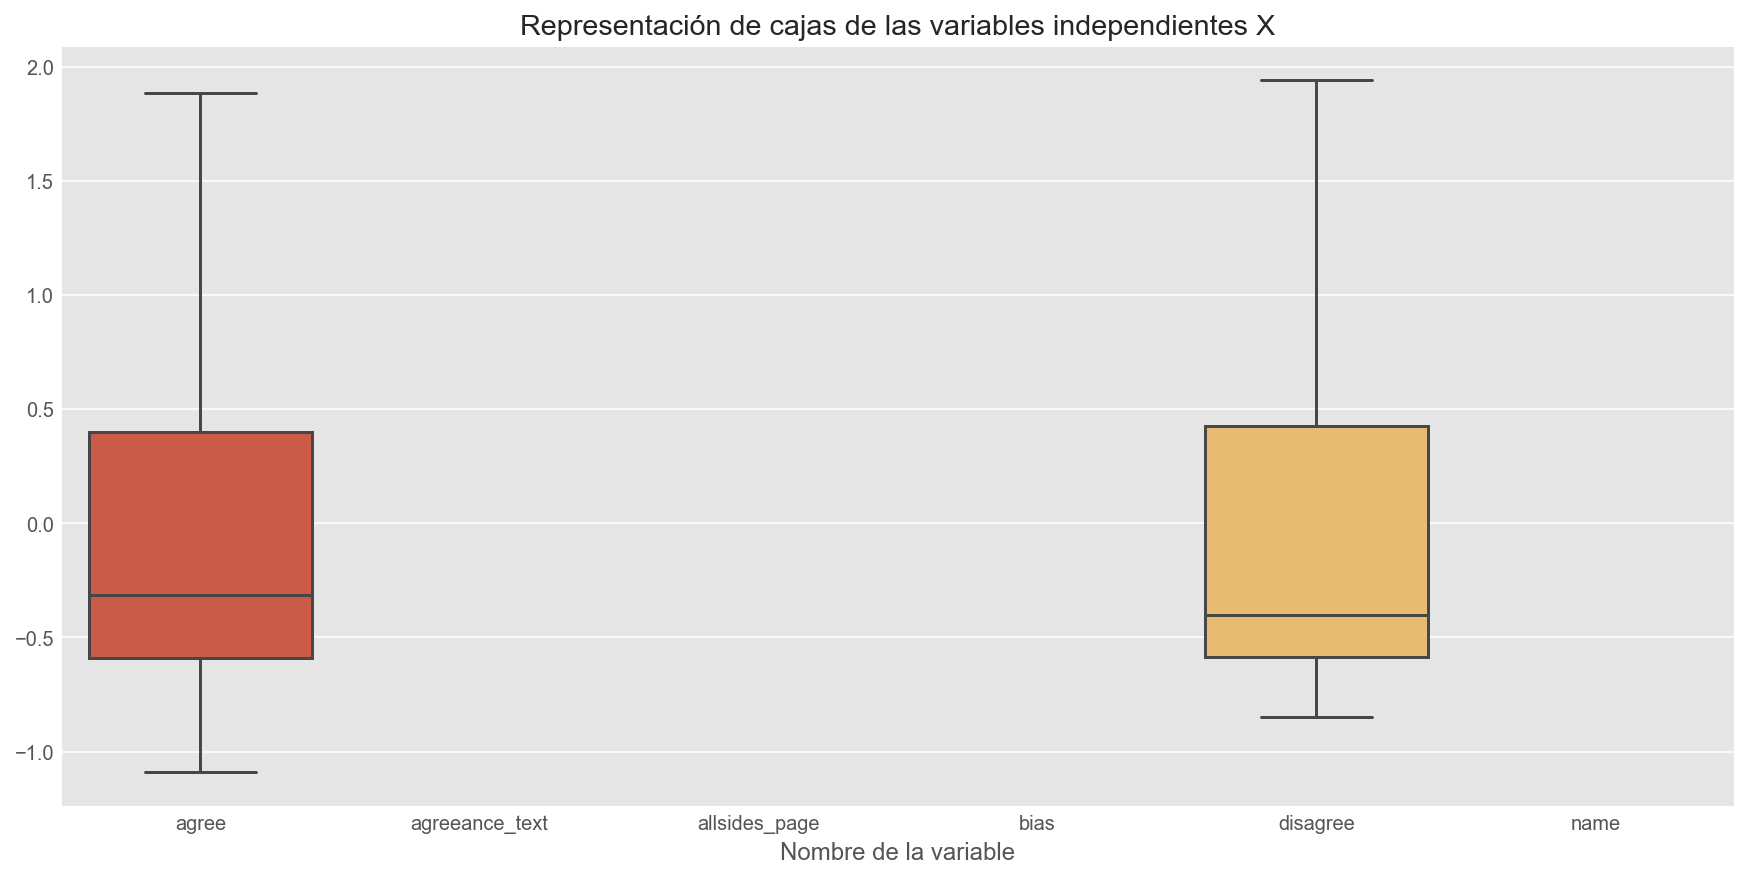

In [28]:
plt.figure(figsize=(15,7))
sns.boxplot(data=X_normalizado)
plt.title(u'Representación de cajas de las variables independientes X')
_ = plt.xlabel('Nombre de la variable')

### La libreria Dtale me ayuda a dar una vision global mas completa, poder combinar analisis en tiempo real y entender mejor los datos

In [29]:
import dtale

In [30]:
dtale.show(df)

## Busqueda de outliers

**Outliers para Agree Ratio**

In [31]:
s = df['agree_ratio']
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr
outliers = dict(s[(s < iqr_lower) | (s > iqr_upper)])

outliers

{19: 6.713487972508591}

**Outliers para Total votes**

In [36]:
s = df['total_votes']
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
iqr_lower = q1 - 1.5 * iqr
iqr_upper = q3 + 1.5 * iqr
outliers = dict(s[(s < iqr_lower) | (s > iqr_upper)])

outliers

{44: 182289, 10: 100764, 16: 91539}

### Hasta aqui hemos realizado el analisis descriptivo, en la cual hemos descubierto cada una de las variables, entendimos su naturaleza y a partir de ello buscaremos relaciones y un diagnostico preciso

### A continuacion Buscaremos comprender el comportamiento de nuestras variables. Para esto utilizaremos un analisis grafico mas profundo

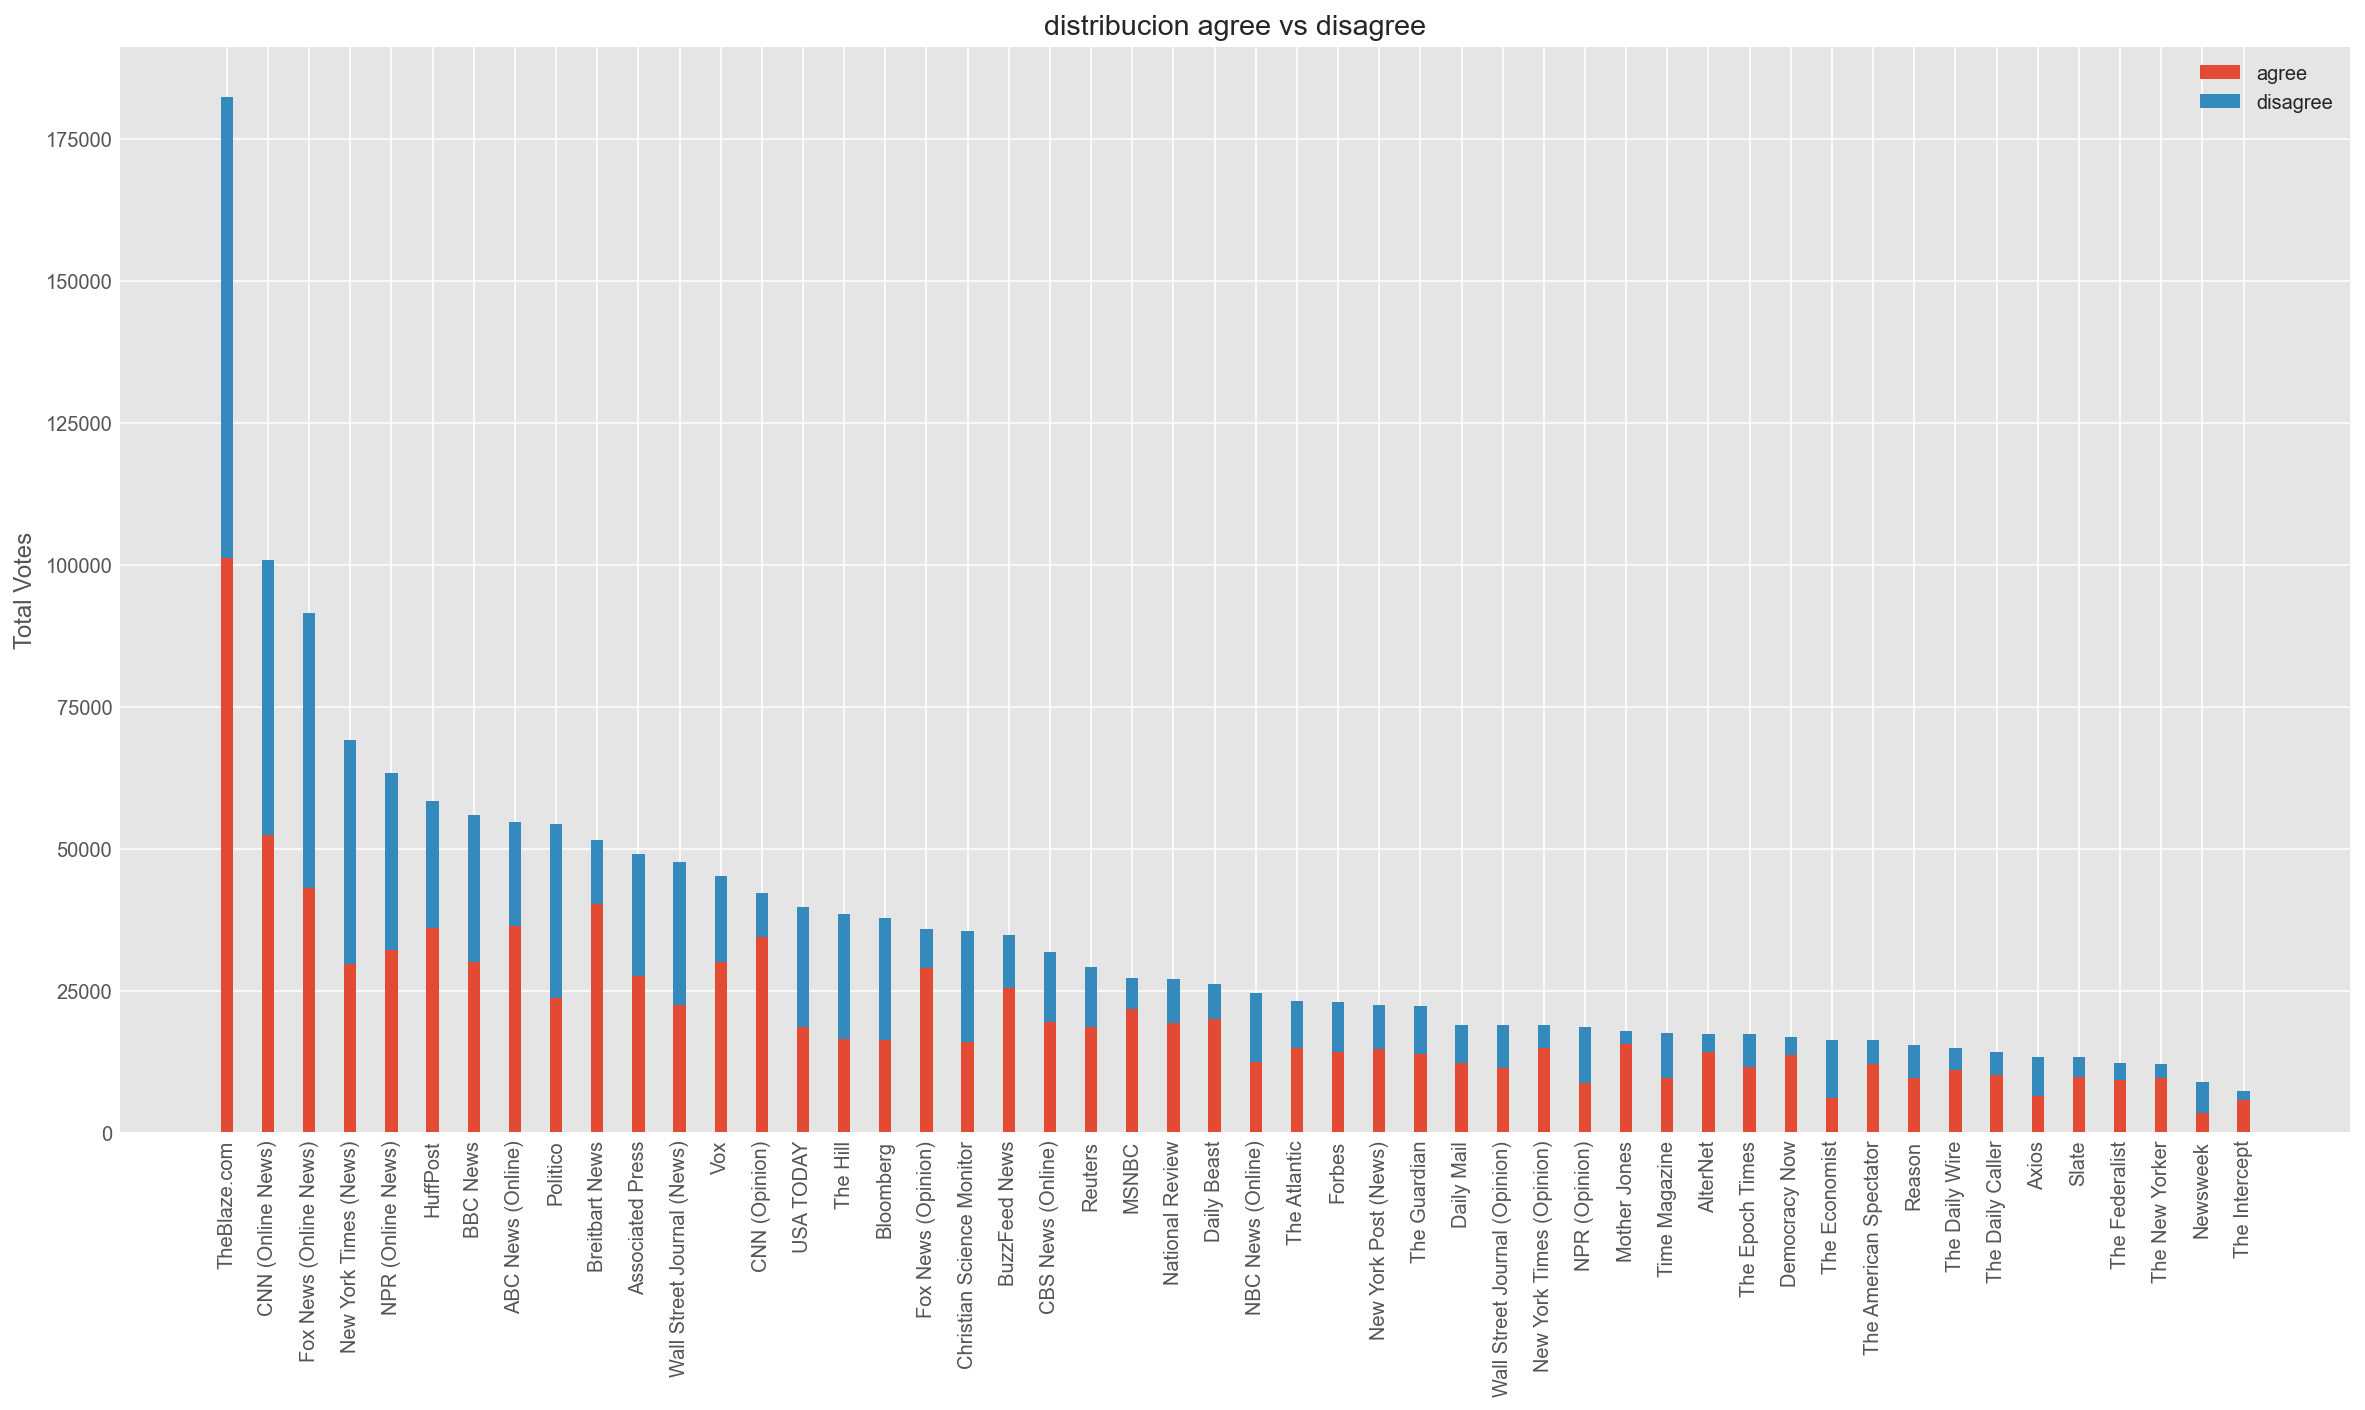

In [37]:
import matplotlib.pyplot as plt


labels = df['name']
agree = df['agree']
disagree = df['disagree']

width = 0.3       # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots(figsize=(20,10))


ax.bar(labels, agree, width, label='agree')
ax.bar(labels, disagree, width, bottom=agree,
       label='disagree')

ax.set_ylabel('Total Votes')
plt.xticks(labels, labels, rotation='vertical')
ax.set_title('distribucion agree vs disagree')
ax.legend()

plt.show()

### A simple vista puede resultar complejo o cargado pero es importante para entender rapiudamente la magnitud de votos que poseen las distintas paginas web, ademas se logra percibir una mayoria para los votantes que estan de acuerdo con el resultado de la votacion.

<AxesSubplot:xlabel='bias', ylabel='count'>

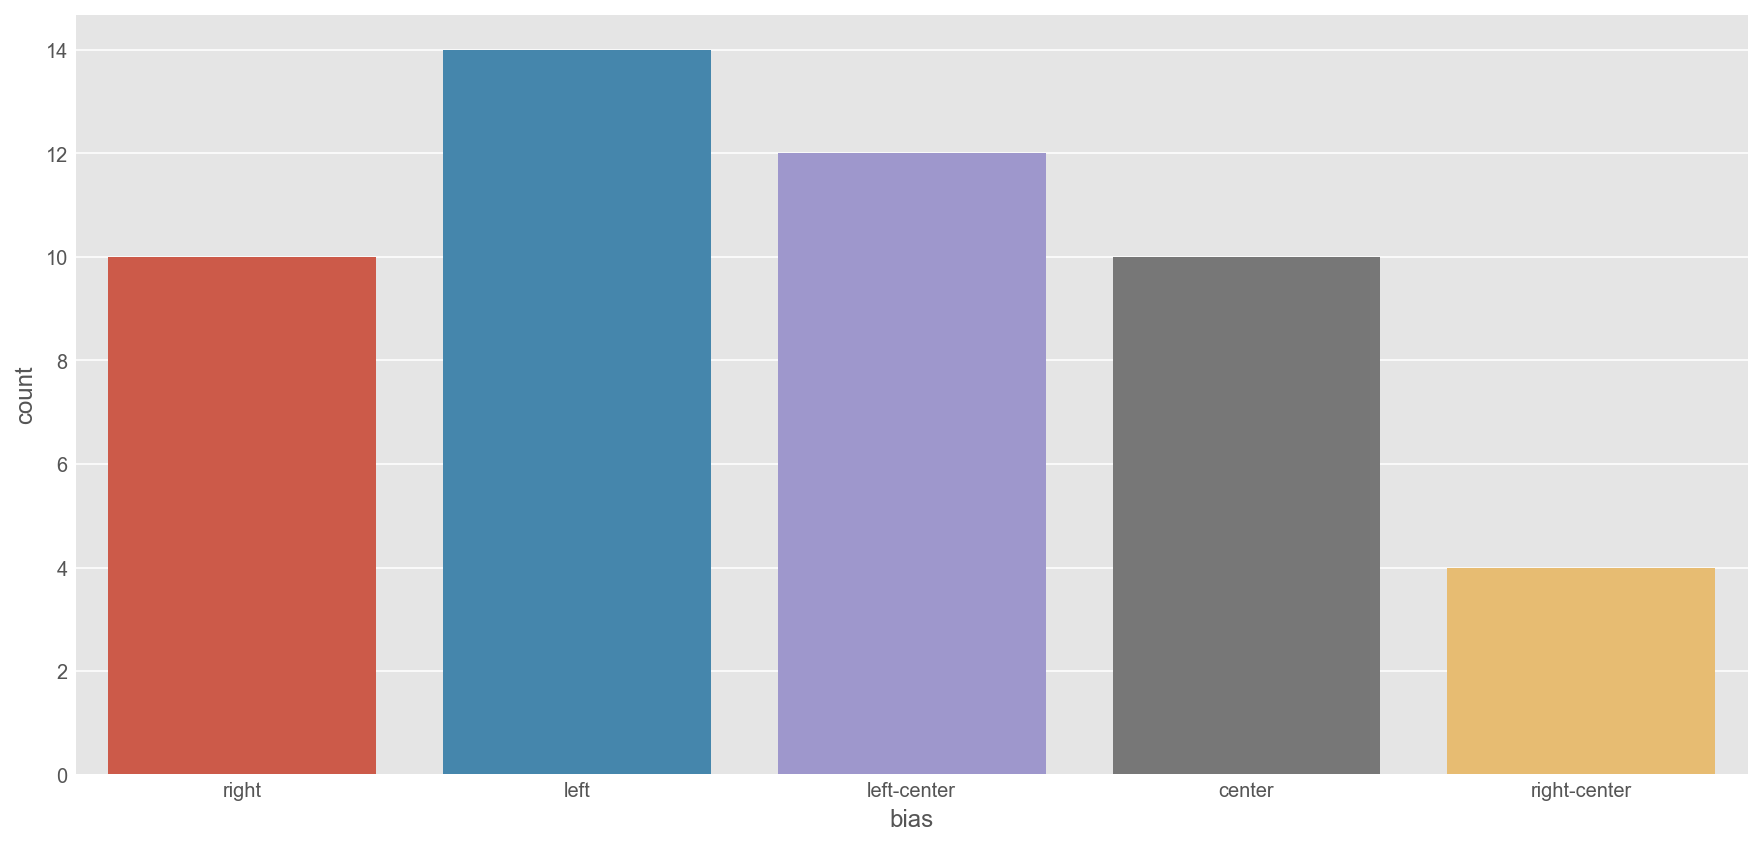

In [38]:
f, ax = plt.subplots(figsize=(15, 7))
sns.countplot(x='bias', data=df) # Para categoricas

<AxesSubplot:xlabel='agreeance_text', ylabel='count'>

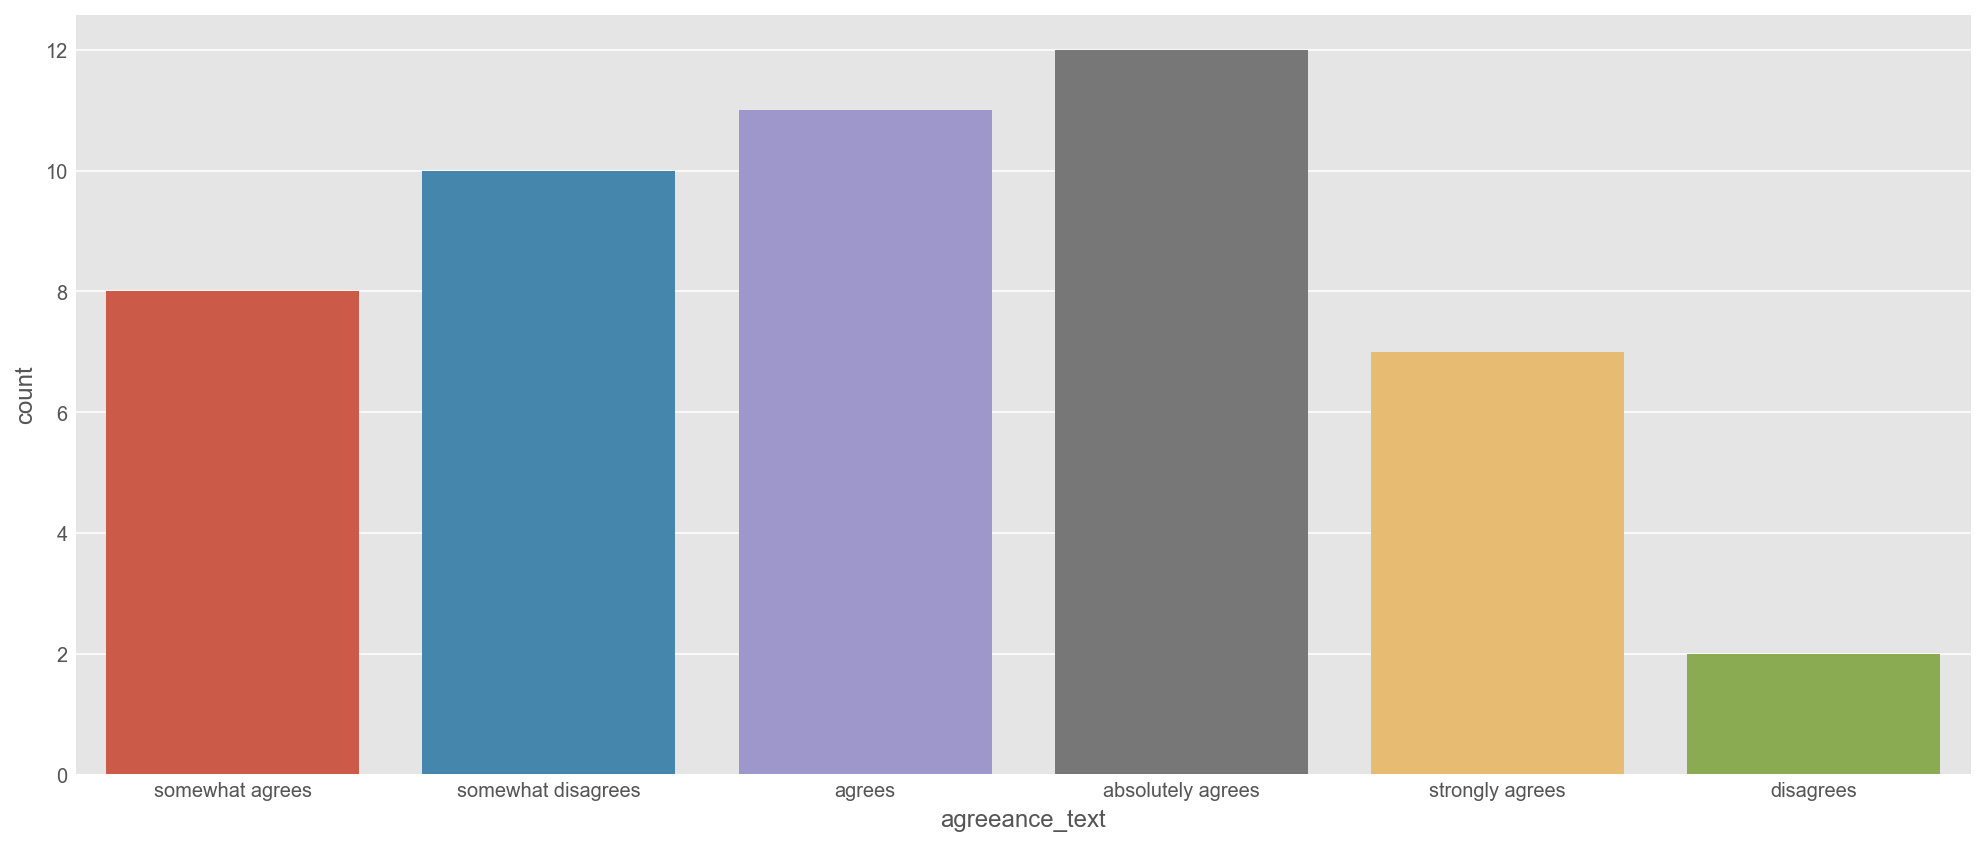

In [39]:
f, ax = plt.subplots(figsize=(17, 7))
sns.countplot(x='agreeance_text', data=df) # Para categoricas

In [40]:
#g = sns.catplot(x="total_votes", y="agreeance_text",
#                hue="agreeance_text", col="bias",
#                data=df, col_wrap=2, kind="bar",
#                height=5, aspect=1, palette="Set3",
#               saturation=1,);
#
#

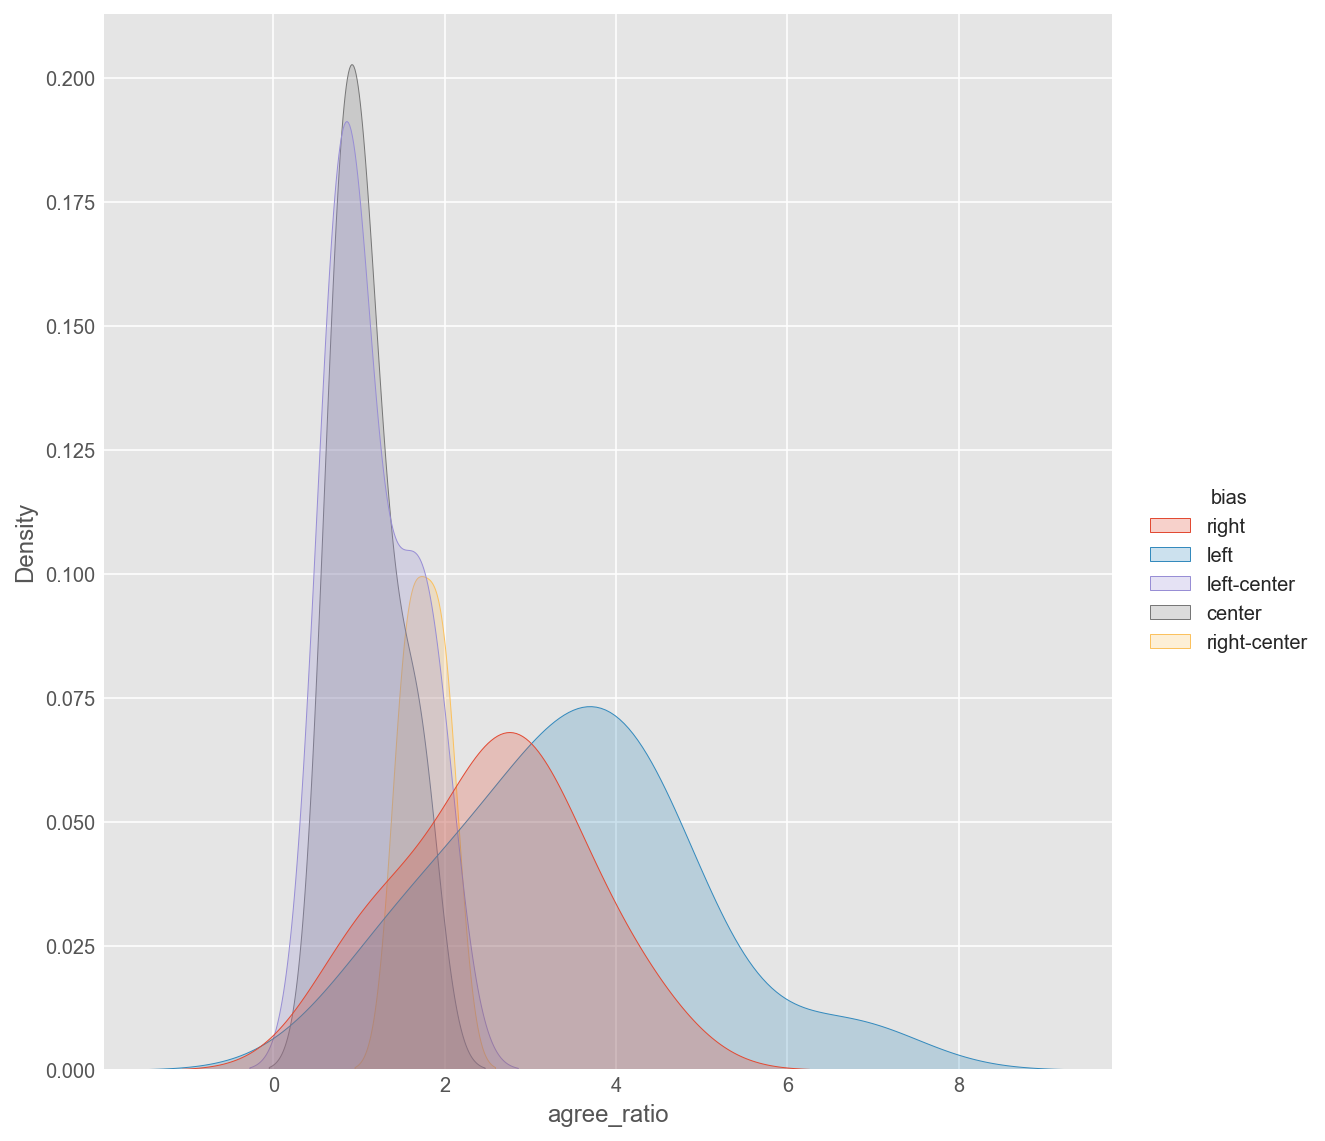

In [41]:
sns.displot(df, x="agree_ratio", hue="bias", kind="kde", fill=True,  height=8, aspect=1)


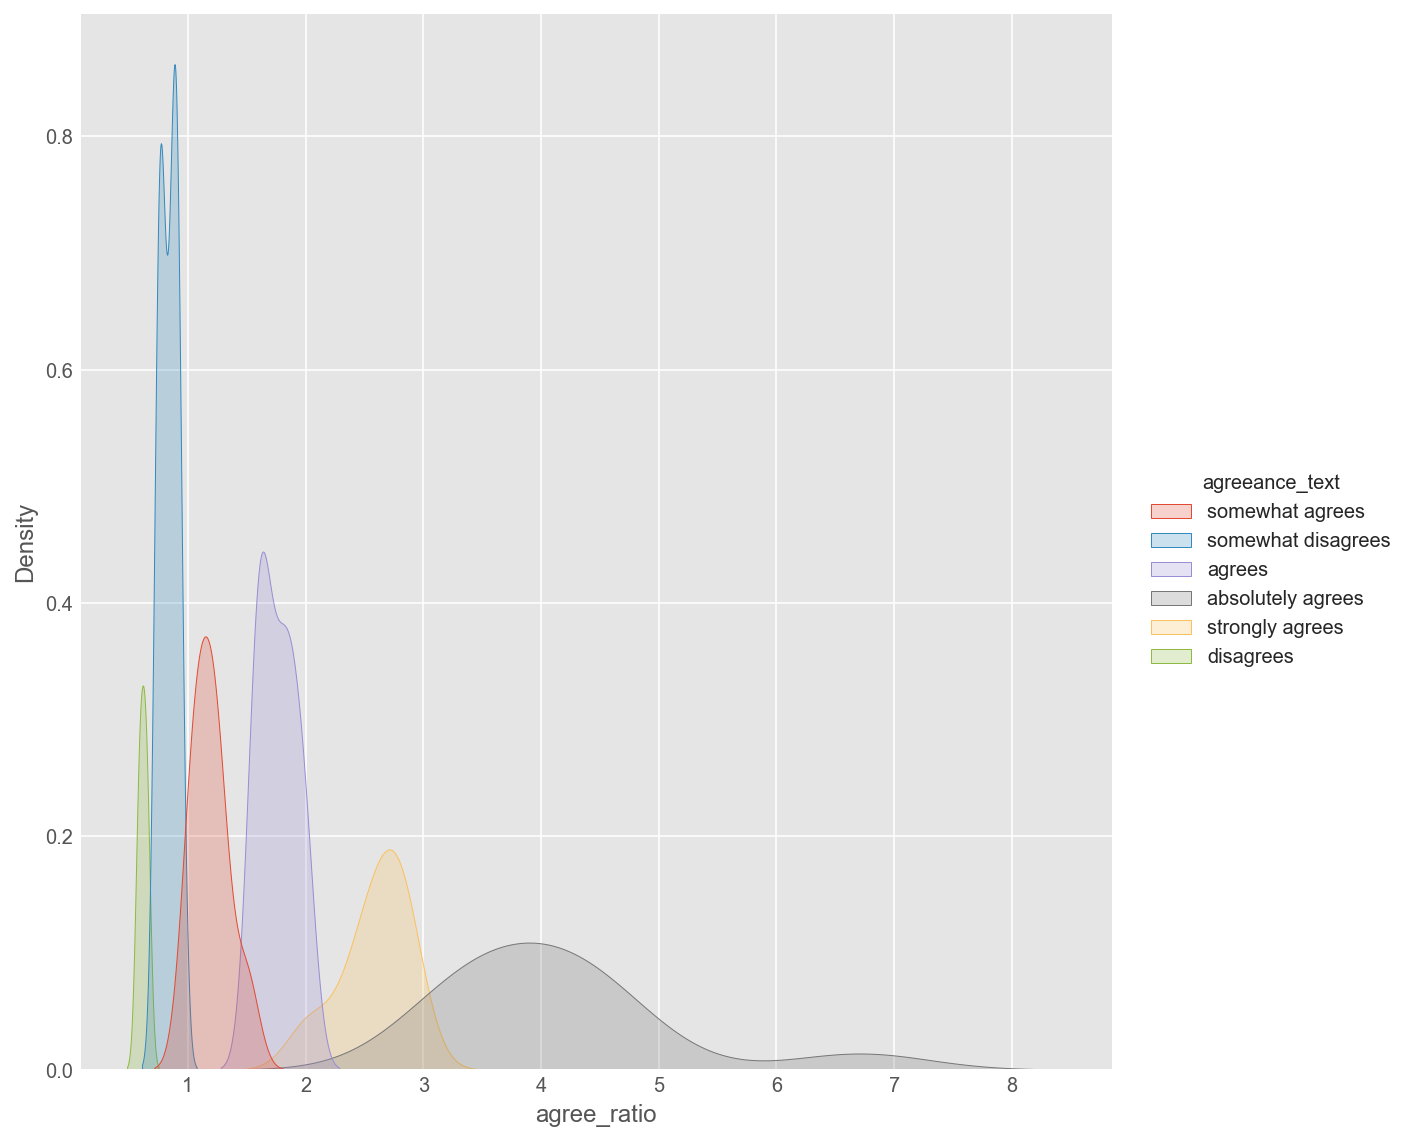

In [42]:
sns.displot(df, x="agree_ratio", hue="agreeance_text", kind="kde", fill=True, height=8, aspect=1)


## Agree ratio

In [43]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  

chart = df.groupby('bias')[['agree_ratio']].agg(['count', 'mean'])
chart.columns = chart.columns.droplevel(0)
chart.columns = ["count", "data"]
chart.index.name = 'labels'
chart = chart.reset_index()
charts = [
	go.Bar(x=chart['labels'].values, y=chart['data'].values),
	go.Scatter(
		x=chart['labels'].values, y=chart['count'].values, yaxis='y2',
		name='Frequency', line={'shape': 'spline', 'smoothing': 0.3}, mode='lines'
	)
]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'agree_ratio(mean) Categorized by bias'},
    'xaxis': {'title': {'text': 'bias'}},
    'yaxis': {'side': 'left', 'title': {'text': 'agree_ratio (mean)'}},
    'yaxis2': {'overlaying': 'y', 'side': 'right', 'title': {'text': 'Frequency'}}
}))
figure

Hay un Bias notable en las posiciones izquiera y derecha. Practicamente la posicion central no aporta un volumen significativo.

In [44]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  

chart_data = pd.concat([
	df['bias'],
	df['agree_ratio'],
], axis=1)
chart_data = chart_data.sort_values(['bias'])
chart_data = chart_data.rename(columns={'bias': 'x'})
chart_data = chart_data.dropna()

charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['agree_ratio']
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'agree_ratio by bias'},
    'xaxis': {'title': {'text': 'bias'}},
    'yaxis': {'title': {'text': 'agree_ratio'}, 'type': 'linear'}
}))
figure

In [45]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  

chart_data = pd.concat([
	df['bias'],
	df['total_votes'],
], axis=1)
chart_data = chart_data.sort_values(['bias'])
chart_data = chart_data.rename(columns={'bias': 'x'})
chart_data = chart_data.dropna()

charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['total_votes']
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'total_votes by bias'},
    'xaxis': {'title': {'text': 'bias'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'total_votes'}, 'type': 'linear'}
}))

figure

In [46]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  

chart_data = pd.concat([
	pd.Series(df.index, index=df.index, name='__index__'),
	df['agreeance_text'],
	df['bias'],
], axis=1)
chart_data = chart_data.query("""(`bias` == 'center') or (`bias` == 'left') or (`bias` == 'left-center') or (`bias` == 'right') or (`bias` == 'right-center')""")
chart_data = chart_data.sort_values(['bias', 'agreeance_text'])
chart_data = chart_data.rename(columns={'agreeance_text': 'x'})
chart_data = chart_data.dropna()

chart_data = chart_data.query("""`bias` == 'center'""")

charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['__index__'],
	name='(bias: center)'
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': '(bias: center) - __index__ by agreeance_text'},
    'xaxis': {'title': {'text': 'agreeance_text'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': '__index__'}, 'type': 'linear'}
}))

figure

In [47]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns] 

chart_data = pd.concat([
	df['agreeance_text'],
	df['total_votes'],
], axis=1)
chart_data = chart_data.sort_values(['agreeance_text'])
chart_data = chart_data.rename(columns={'agreeance_text': 'x'})
chart_data = chart_data.dropna()


charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['total_votes']
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'total_votes by agreeance_text'},
    'xaxis': {'title': {'text': 'agreeance_text'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'total_votes'}, 'type': 'linear'}
}))
figure

In [48]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  

chart_data = pd.concat([
	df['agreeance_text'],
	df['agree_ratio'],
], axis=1)
chart_data = chart_data.sort_values(['agreeance_text'])
chart_data = chart_data.rename(columns={'agreeance_text': 'x'})
chart_data = chart_data.dropna()


charts = []
charts.append(go.Bar(
	x=chart_data['x'],
	y=chart_data['agree_ratio']
))
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'agree_ratio by agreeance_text'},
    'xaxis': {'title': {'text': 'agreeance_text'}},
    'yaxis': {'title': {'text': 'agree_ratio'}, 'type': 'linear'}
}))
figure

## ¿Con qué calificaciones de los medios está absolutamente de acuerdo la comunidad ?

Para encontrar dónde la comunidad está absolutamente de acuerdo, podemos hacer una simple lista de comprensión que verifica cada uno dictpara el texto de acuerdo que queremos:

In [49]:
abs_agree = [d for d in data if d['agreeance_text'] == 'absolutely agrees']

print(f"{'Outlet':<20} {'Bias':<20}")
print("-" * 30)

for d in abs_agree:
    print(f"{d['name']:<20} {d['bias']:<20}")

Outlet               Bias                
------------------------------
AlterNet             left                
Breitbart News       right               
CNN (Opinion)        left                
Daily Beast          left                
Democracy Now        left                
Fox News (Opinion)   right               
Mother Jones         left                
MSNBC                left                
New York Times (Opinion) left                
The Federalist       right               
The Intercept        left                
The New Yorker       left                


In [50]:
df[df['agreeance_text'] == 'somewhat disagrees']

name  \
2       Fox News (Online News)   
3        New York Times (News)   
8                     Politico   
11  Wall Street Journal (News)   
14                   USA TODAY   
15                    The Hill   
16                   Bloomberg   
18   Christian Science Monitor   
33               NPR (Opinion)   
44                       Axios   

                                        allsides_page         bias  agree  \
2   https://www.allsides.com/news-source/fox-news-...        right  43118   
3   https://www.allsides.com/news-source/new-york-...  left-center  29625   
8   https://www.allsides.com/news-source/politico-...  left-center  23728   
11  https://www.allsides.com/news-source/wall-stre...       center  22438   
14  https://www.allsides.com/news-source/usa-today...  left-center  18699   
15  https://www.allsides.com/news-source/hill-medi...       center  16429   
16  https://www.allsides.com/news-source/bloomberg...  left-center  16326   
18  https://www.allsides.com/news-source/christian...       center  15912   
33  https://www.allsides.com/news-source/npr-edito...  left-center   8688   
44         https://www.allsides.com/news-source/axios       center   6489   

    disagree  agree_ratio      agreeance_text  total_votes  
2      48421     0.890481  somewhat disagrees        91539  
3      39427     0.751389  somewhat disagrees        69052  
8      30561     0.776414  somewhat disagrees        54289  
11     25211     0.890008  somewhat disagrees        47649  
14     21003     0.890301  somewhat disagrees        39702  
15     22032     0.745688  somewhat disagrees        38461  
16     21476     0.760197  somewhat disagrees        37802  
18     19516     0.815331  somewhat disagrees        35428  
33      9877     0.879619  somewhat disagrees        18565  
44      6918     0.937988  somewhat disagrees        13407

In [51]:
df[df['agreeance_text'] == 'strongly disagrees']

Empty DataFrame
Columns: [name, allsides_page, bias, agree, disagree, agree_ratio, agreeance_text, total_votes]
Index: []

Aqui tuve ciertos problemas dado que el articulo que utilice como guia, no excplicaba correctamete o al menos me genero muchos errores, agregar la informacion de las distintas pestañas de la pagina.

In [52]:
df['total_votes'] = df['agree'] + df['disagree']
df.sort_values('total_votes', ascending=False, inplace=True)

df

name  \
0                    TheBlaze.com   
1               CNN (Online News)   
2          Fox News (Online News)   
3           New York Times (News)   
4               NPR (Online News)   
5                        HuffPost   
6                        BBC News   
7               ABC News (Online)   
8                        Politico   
9                  Breitbart News   
10               Associated Press   
11     Wall Street Journal (News)   
12                            Vox   
13                  CNN (Opinion)   
14                      USA TODAY   
15                       The Hill   
16                      Bloomberg   
17             Fox News (Opinion)   
18      Christian Science Monitor   
19                  BuzzFeed News   
20              CBS News (Online)   
21                        Reuters   
22                          MSNBC   
23                National Review   
24                    Daily Beast   
25              NBC News (Online)   
26                   The Atlantic   
27                         Forbes   
28           New York Post (News)   
29                   The Guardian   
30                     Daily Mail   
31  Wall Street Journal (Opinion)   
32       New York Times (Opinion)   
33                  NPR (Opinion)   
34                   Mother Jones   
35                  Time Magazine   
36                       AlterNet   
37                The Epoch Times   
38                  Democracy Now   
39                  The Economist   
40         The American Spectator   
41                         Reason   
42                 The Daily Wire   
43               The Daily Caller   
44                          Axios   
45                          Slate   
46                 The Federalist   
47                 The New Yorker   
48                       Newsweek   
49                  The Intercept   

                                        allsides_page          bias   agree  \
0   https://www.allsides.com/news-source/theblaze-...         right  101179   
1   https://www.allsides.com/news-source/cnn-media...          left   52470   
2   https://www.allsides.com/news-source/fox-news-...         right   43118   
3   https://www.allsides.com/news-source/new-york-...   left-center   29625   
4   https://www.allsides.com/news-source/npr-media...        center   32167   
5   https://www.allsides.com/news-source/huffpost-...          left   35997   
6   https://www.allsides.com/news-source/bbc-news-...        center   30086   
7   https://www.allsides.com/news-source/abc-news-...   left-center   36426   
8   https://www.allsides.com/news-source/politico-...   left-center   23728   
9      https://www.allsides.com/news-source/breitbart         right   40209   
10  https://www.allsides.com/news-source/associate...        center   27609   
11  https://www.allsides.com/news-source/wall-stre...        center   22438   
12  https://www.allsides.com/news-source/vox-news-...          left   30105   
13  https://www.allsides.com/news-source/cnn-edito...          left   34536   
14  https://www.allsides.com/news-source/usa-today...   left-center   18699   
15  https://www.allsides.com/news-source/hill-medi...        center   16429   
16  https://www.allsides.com/news-source/bloomberg...   left-center   16326   
17  https://www.allsides.com/news-source/fox-news-...         right   29071   
18  https://www.allsides.com/news-source/christian...        center   15912   
19  https://www.allsides.com/news-source/buzzfeed-...          left   25413   
20  https://www.allsides.com/news-source/cbs-news-...   left-center   19411   
21       https://www.allsides.com/news-source/reuters        center   18595   
22         https://www.allsides.com/news-source/msnbc          left   21726   
23  https://www.allsides.com/news-source/national-...         right   19269   
24  https://www.allsides.com/news-source/daily-bea...          left   19957   
25  https://www.allsides.com/news-source/nbc-news-...   left-center   12407   
26      

In [53]:
df2 = df.head(25).copy()

df2.head()

name                                      allsides_page  \
0            TheBlaze.com  https://www.allsides.com/news-source/theblaze-...   
1       CNN (Online News)  https://www.allsides.com/news-source/cnn-media...   
2  Fox News (Online News)  https://www.allsides.com/news-source/fox-news-...   
3   New York Times (News)  https://www.allsides.com/news-source/new-york-...   
4       NPR (Online News)  https://www.allsides.com/news-source/npr-media...   

          bias   agree  disagree  agree_ratio      agreeance_text  total_votes  
0        right  101179     81110     1.247429     somewhat agrees       182289  
1         left   52470     48294     1.086470     somewhat agrees       100764  
2        right   43118     48421     0.890481  somewhat disagrees        91539  
3  left-center   29625     39427     0.751389  somewhat disagrees        69052  
4       center   32167     31103     1.034209     somewhat agrees        63270

Con las 25 fuentes de noticias principales por cantidad de comentarios, creemos un gráfico de barras apiladas donde la cantidad de personas de acuerdo se apilan encima de la cantidad de desacuerdos . Esto hace que la altura total de la barra sea la cantidad total de retroalimentación.

A continuación, primero creamos una figura y ejes, trazamos las barras de acuerdo, trazamos las barras de desacuerdo encima de las de acuerdo usando bottomy luego configuramos varias características de text

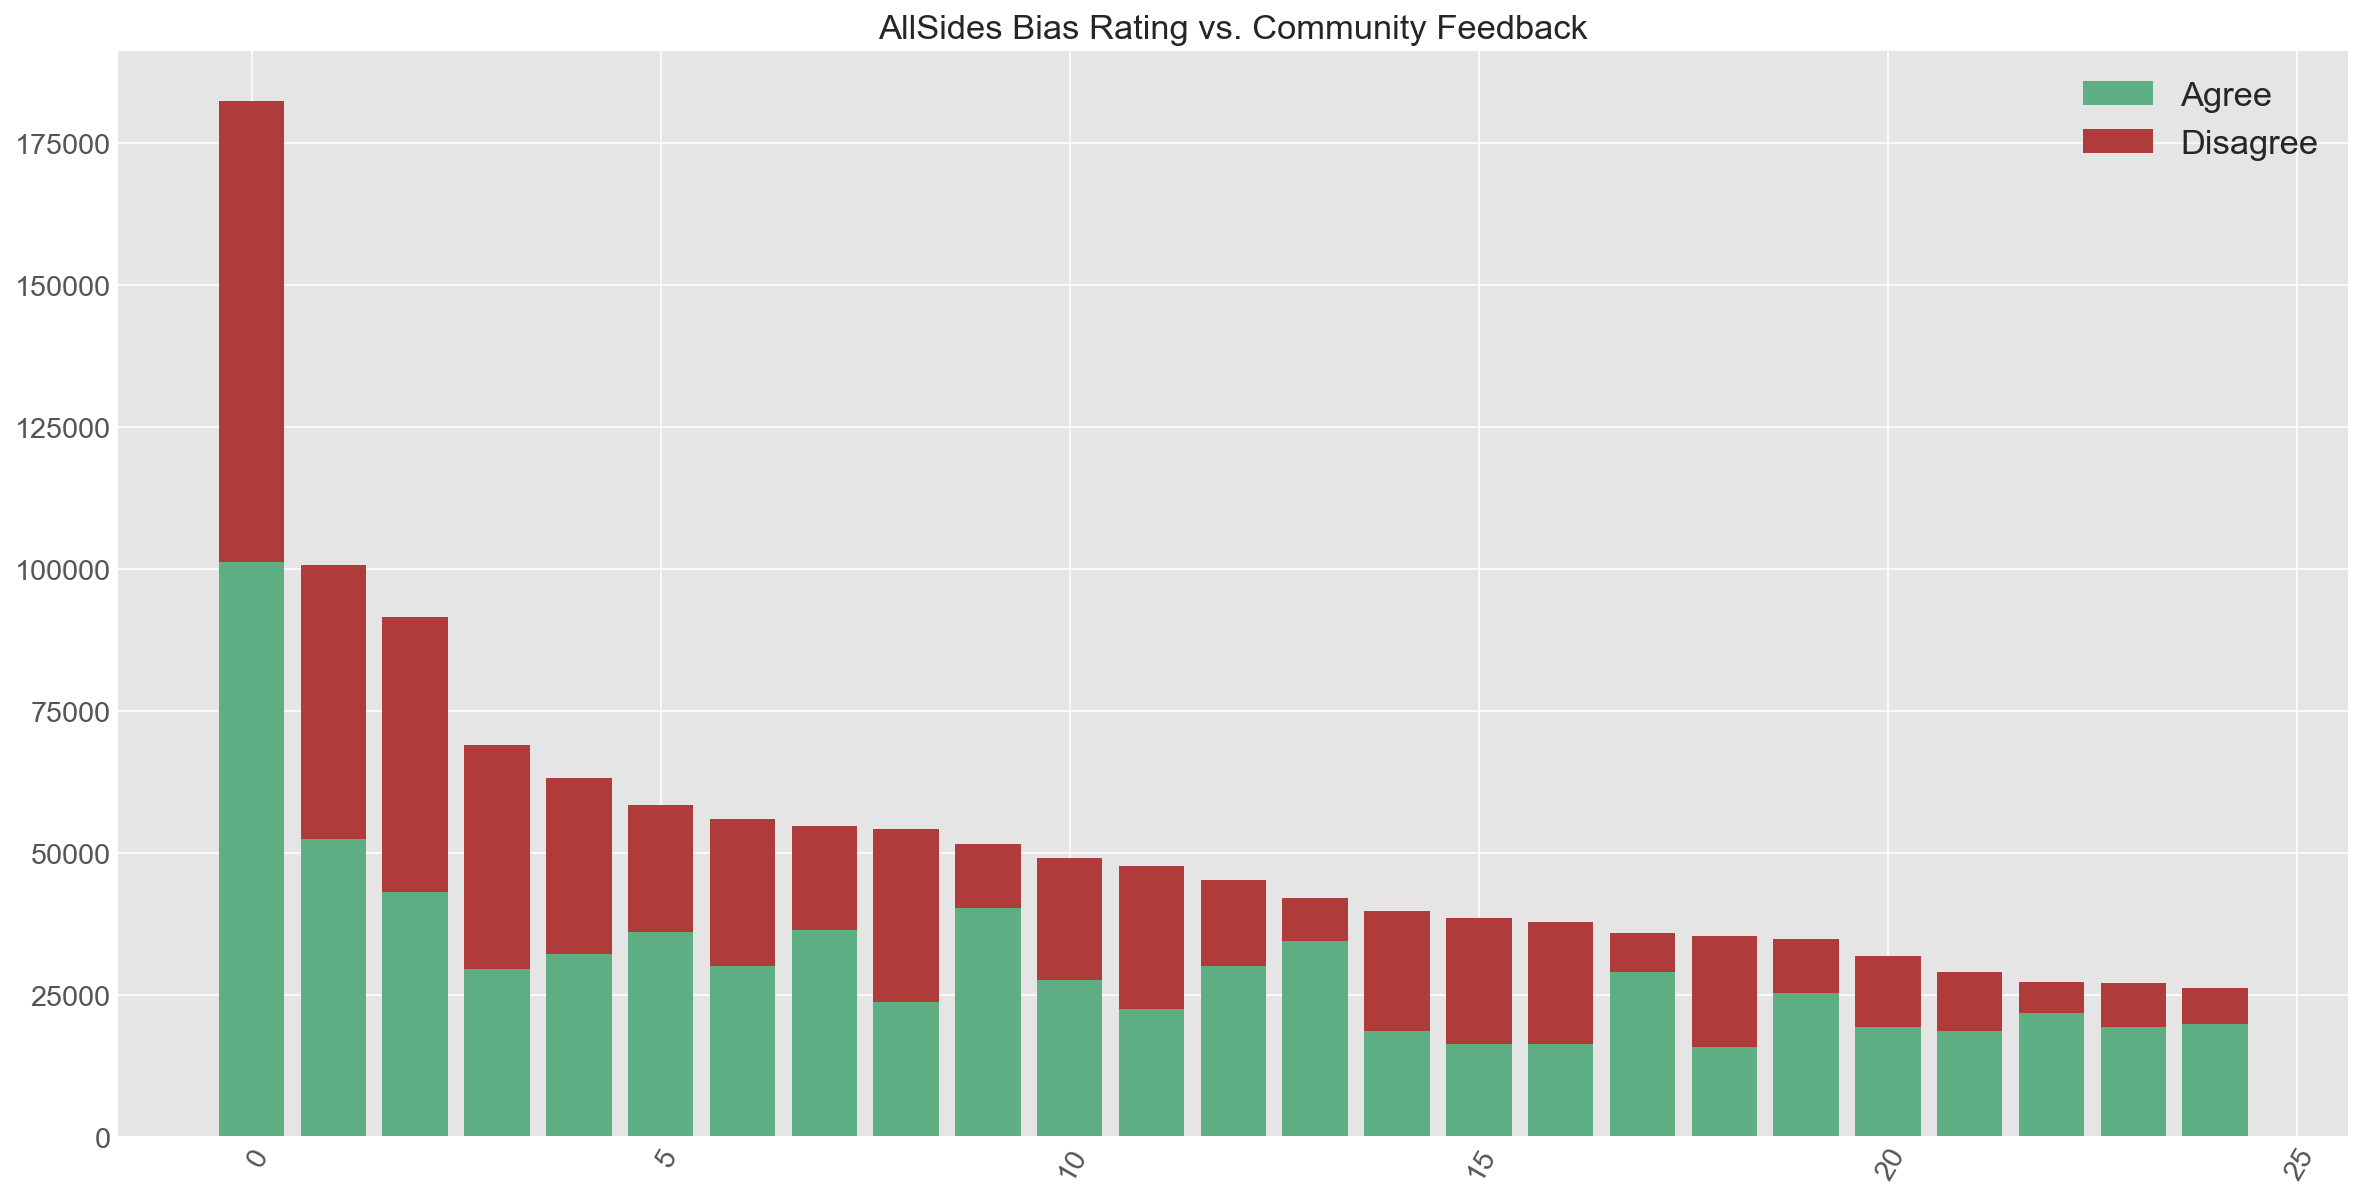

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(df2.index, df2['agree'], color='#5DAF83')
ax.bar(df2.index, df2['disagree'], bottom=df2['agree'], color='#AF3B3B')

ax.set_ylabel = 'Total feedback'

plt.yticks(fontsize='x-large')
plt.xticks(rotation=60, ha='right', fontsize='x-large', rotation_mode='anchor')

plt.legend(['Agree', 'Disagree'], fontsize='xx-large')
plt.title('AllSides Bias Rating vs. Community Feedback', fontsize='xx-large')
plt.show()

Para una versión un poco más compleja, hice una subtrama para cada sesgo y trace las respectivas fuentes de noticias.

Esta vez haremos una nueva copia del DataFrame original de antemano, ya que ahora podemos trazar más medios de comunicación.


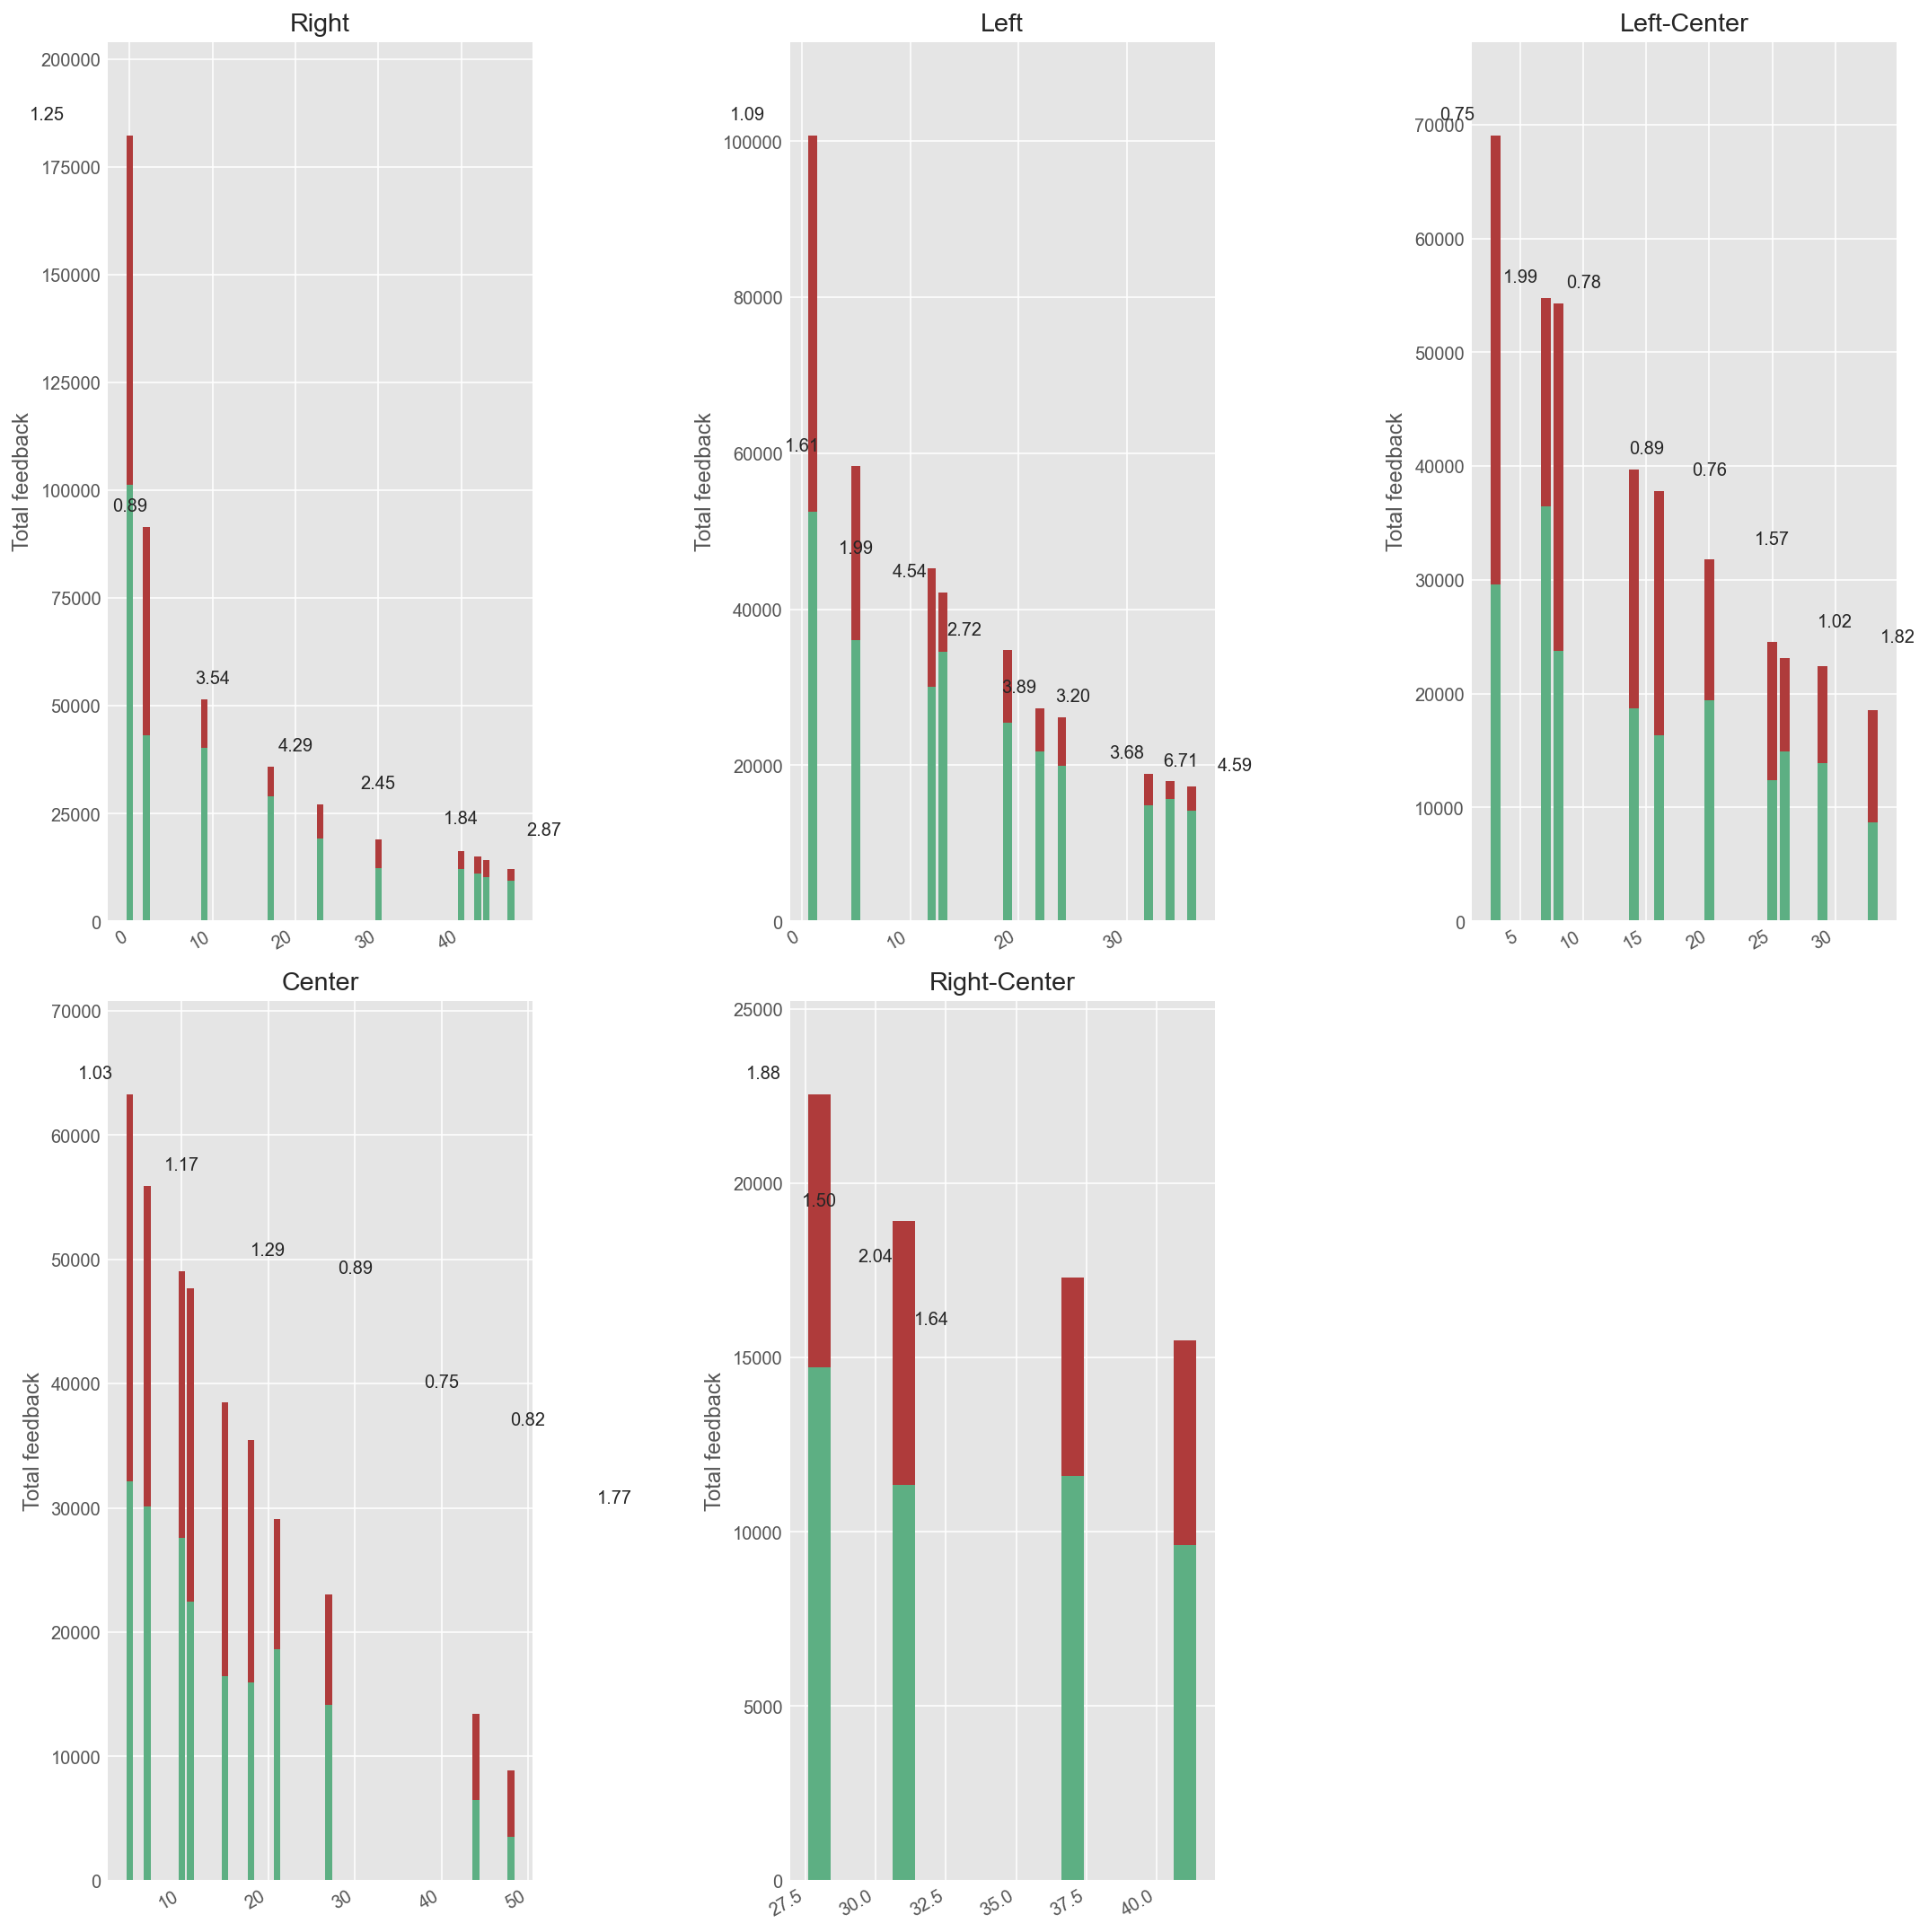

In [55]:
df3 = df.copy()

fig = plt.figure(figsize=(15,15))

biases = df3['bias'].unique()

for i, bias in enumerate(biases):
    # Get top 10 news sources for this bias and sort index alphabetically
    temp_df = df3[df3['bias'] == bias].iloc[:10]
    temp_df.sort_index(inplace=True)
    
    # Get max votes, i.e. the y value for tallest bar in this temp dataframe
    max_votes = temp_df['total_votes'].max()
    
    # Add a new subplot in the correct grid position
    ax = fig.add_subplot(len(biases) / 2, 3, i + 1)
    
    # Create the stacked bars
    ax.bar(temp_df.index, temp_df['agree'], color='#5DAF83')
    ax.bar(temp_df.index, temp_df['disagree'], bottom=temp_df['agree'], color='#AF3B3B')
    
    # Place text for the ratio on top of each bar
    for x, y, ratio in zip(ax.get_xticks(), temp_df['total_votes'], temp_df['agree_ratio']):
        ax.text(x, y + (0.02 * max_votes), f"{ratio:.2f}", ha='center')
    
    ax.set_ylabel('Total feedback')
    ax.set_title(bias.title())
    
    # Make y limit larger to compensate for text on bars
    ax.set_ylim(0, max_votes + (0.12 * max_votes))
    
    # Rotate tick labels so they don't overlap
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout(w_pad=4.0, h_pad=1.0)
plt.show()

Al interpretar estas gráficas, tenga en cuenta que el eje y tiene diferentes escalas para cada subparcela. En general, es una buena manera de ver qué medios tienen muchos votos y dónde está el mayor desacuerdo.

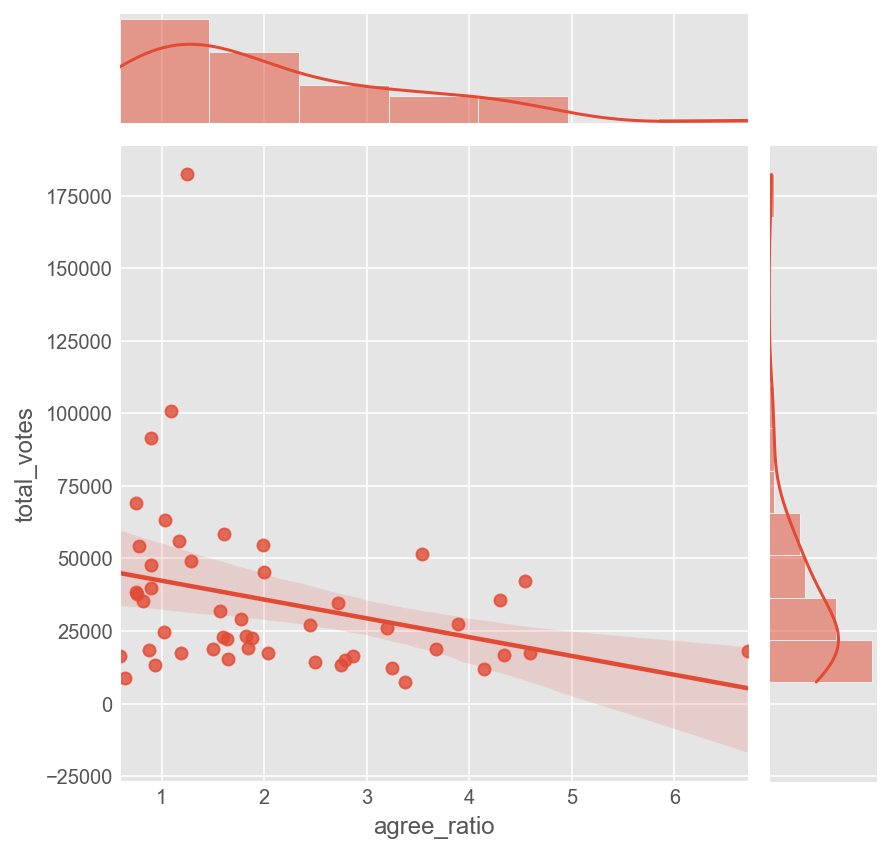

In [56]:
sns.jointplot(x='agree_ratio', y='total_votes', data=df, kind='reg') # cuadrod e doble entrada 

### SE VE NOTORIAMENTE QUE EL RATIO SE INCLINA PARA EL LADO DE LOS AGREE, ESTO PUEDE SER DEBIDO AL OUTLIER QUE PRESENTA UNA DE LAS PAGINAS WEB. NO NECESARIAMENTE SEA UN VALOR ERRORNEO, SIMPLEMENTE PUEDE TENER MUCHAS MAS VISUALIZACIONES QUE LAS DEMAS PAGINAS.